In [1]:
import albumentations as alb
import numpy as np
import os
import time
import uuid
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import json

In [3]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    return img

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [26]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                            alb.HorizontalFlip(p=0.5),
                            alb.RandomBrightnessContrast(p=0.2),
                            alb.RandomGamma(p=0.2),
                            alb.RGBShift(p=0.2),
                            alb.VerticalFlip(p=0.5)],
                           bbox_params=alb.BboxParams(format='albumentations',
                                                        label_fields=['class_labels']))



In [27]:
img = cv2.imread(os.path.join('data','test', 'images','afc97194-eb02-11ed-956f-98e7432e0540.jpg'))
with open(os.path.join('data', 'test', 'labels', 'afc97194-eb02-11ed-956f-98e7432e0540.json'), 'r') as f:
    label = json.load(f)

In [28]:
label['shapes'][0]['points']
label['shapes'][0]['label']

'areesha'

In [29]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

            class_label = label['shapes'][0]['label']

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=[class_label])
                cv2.imwrite(os.path.join('new_aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image']) # save image

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = [1, 0, 0, 0]
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        if augmented['class_labels'][0] == 'suleman':
                            annotation['class'] = [0, 1, 0, 0]
                        elif augmented['class_labels'][0] == 'areesha':
                            annotation['class'] = [0, 0, 1, 0]
                        elif augmented['class_labels'][0] == 'subhan':
                            annotation['class'] = [0, 0, 0, 1]

                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = [1, 0, 0, 0]


                with open(os.path.join('new_aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.05623413705583755, 0.9431049069373943, 0.0, 0.6381909193457418, 'subhan'].
x_max is less than or equal to x_min for bbox [0.04354378172588831, 0.9431049069373943, 0.001506979695431454, 0.6575719120135364, 'subhan'].
x_max is less than or equal to x_min for bbox [0.996113578680203, 0.940989847715736, 0.849381345177665, 0.42491539763113373, 'subhan'].
y_max is less than or equal to y_min for bbox [0.002300126903553279, 0.991751269035533, 0.1347557106598985, 0.5497038917089678, 'suleman'].
y_max is less than or equal to y_min for bbox [0.002300126903553279, 0.9896362098138749, 0.13078997461928932, 0.5571065989847717, 'suleman'].
y_max is less than or equal to y_min for bbox [0.004679568527918776, 0.9727157360406091, 0.11096129441624365, 0.5042301184433164, 'suleman'].
y_max is less than or equal to y_min for bbox [0.006265862944162426, 0.9906937394247038, 0.08716687817258881, 0.6057529610829103, 'suleman'].
y_max is less than or equal to y_

# Load Images

In [39]:
train_images = tf.data.Dataset.list_files('new_aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [40]:
test_images = tf.data.Dataset.list_files('new_aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)


In [32]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

# Load Labels

In [67]:
train_labels = tf.data.Dataset.list_files('new_aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
# make it 1d
train_labels = train_labels.map(lambda x,y: (x[0], y))


In [68]:
test_labels = tf.data.Dataset.list_files('new_aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
# make it 1d
test_labels = test_labels.map(lambda x,y: (x[0], y))


In [69]:
val_labels = tf.data.Dataset.list_files('new_aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
# make it 1d
val_labels = val_labels.map(lambda x,y: (x[0], y))

In [70]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(6540, 6540, 1140, 1140, 720, 720)

In [91]:
# shape of labels
for x in train_labels.take(1):

    print(x[0].shape)
    print(x[1].shape)

(4,)
(4,)


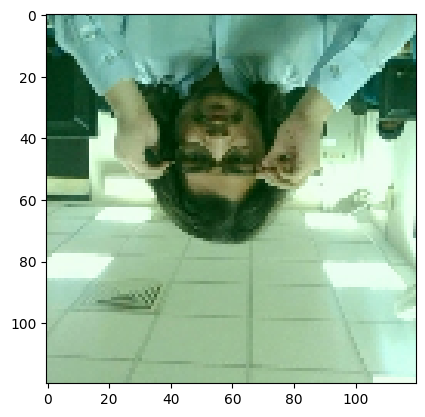

[0 0 0 1]
[0.2136 0.1819 0.748  0.612 ]


In [72]:
# print labels and corresponding images

for x in train_images.take(1):
    
        plt.imshow(x.numpy())
        plt.show()

for x in train_labels.take(1):
    print(x[0].numpy())
    print(x[1].numpy())




# Merge Images and Labels

In [73]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [74]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [75]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [76]:
res = train.as_numpy_iterator().next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1 0 0]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]


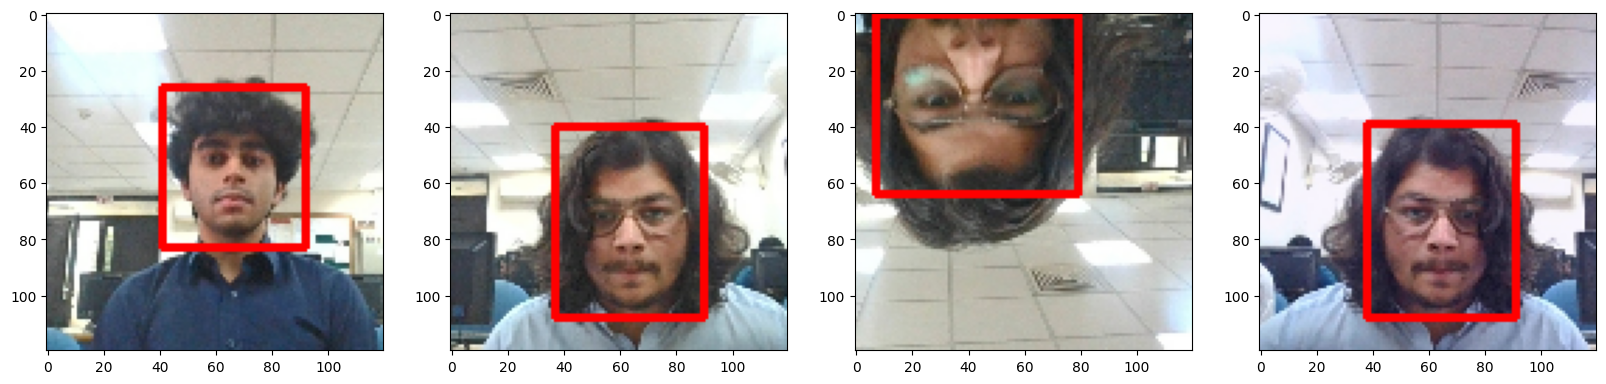

In [77]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    sample_class = res[1][0][idx]
    print(sample_class)
    


    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)
    # print class label
    

    ax[idx].imshow(sample_image)

In [78]:
# show coords of first image
res[1][1][0]

# show class of first image
res[1][0][0]

array([0, 1, 0, 0], dtype=uint8)

## Building model

In [79]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [80]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [81]:
def build_model():

    input_layer = Input(shape=(120,120,3))
    vgg = VGG16(include_top=False)(input_layer)

     # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(4, activation='softmax')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [82]:
facetracker = build_model()
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_5[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [83]:
batches_per_epoch = len(train_images)
lr_decay = (1./0.75 - 1) / batches_per_epoch

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=batches_per_epoch,
    decay_rate=0.75)

In [84]:
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [85]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [86]:
classloss = tf.keras.losses.CategoricalCrossentropy()
regressloss = localization_loss

In [87]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [88]:
model = FaceTracker(facetracker)

In [89]:
model.compile(opt, classloss, regressloss)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val)

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [92]:
# load model.h5 file

facetracker = tf.keras.models.load_model('multi_class_facetracker.h5')
# compile model

## Testing model

In [93]:
test_data = test.as_numpy_iterator()

In [118]:
test_sample = test_data.next()

In [119]:
y_pred_class, y_pred_coords = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 456ms/step


In [120]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 448ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Areesha
Areesha
Areesha
Subhan


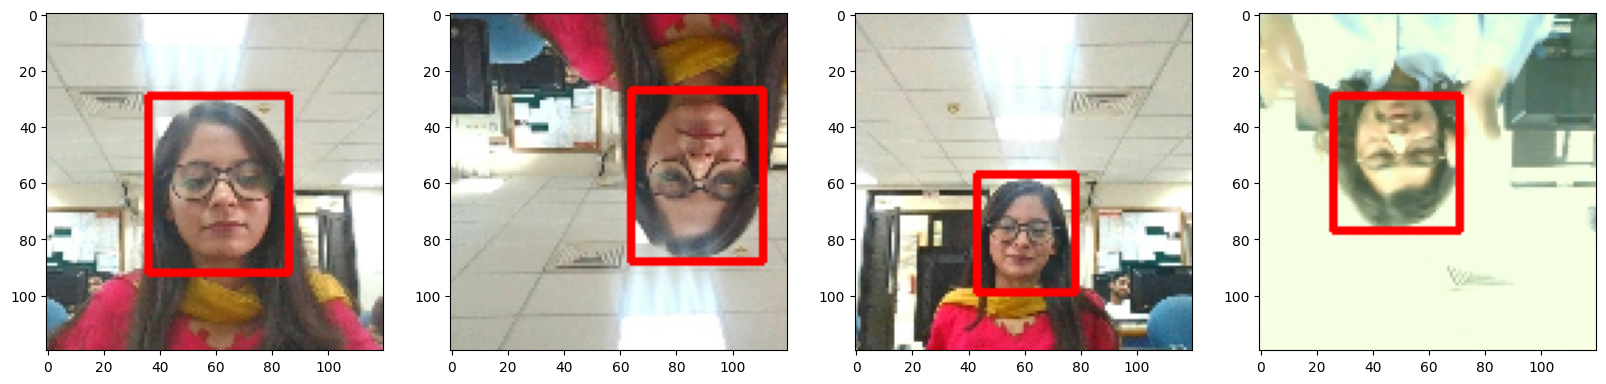

In [121]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
   
   # print labels
    label = np.argmax(yhat[0][idx])
    if (label == 0):
        label = ""
    elif (label == 1):
        label = "Suleman"
    elif (label == 2):
        label = "Areesha"
    elif (label == 3):
        label = "Subhan"
    
    print (label)
    
    ax[idx].imshow(sample_image)